# Acoustic localization

Acoustic localization is a method for identifying the location of a sound-source, based on the time delays of arrival (TDOAs) between multiple time-synchronized audio recordings. This notebook outlines how you can use Opensoundscape's localization module to for acoustic localization. There are multiple steps involved in using an array of audio receivers to identify sound source locations. These include: 
1. Deploying time-synchronizable recording devices at static, known locations. 
2. Synchronizing recordings. 
3. Labeling the detections of your sound of interest in the audio. 
4. Estimating the time delays of arrival (TDOAs) of the sound of interest between multiple microphones.
5. Localizing the sound source from TDOAs.
6. Assessing the confidence of these localizations.

This notebook will focus mostly on steps 3 onwards, as the details of steps 1 and 2 depend on your choice of hardware.

## Run this tutorial

This tutorial is more than a reference! It's a Jupyter Notebook which you can run and modify on Google Colab or your own computer.

|Link to tutorial|How to run tutorial|
| :- | :- |
| [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kitzeslab/opensoundscape/blob/master/docs/tutorials/acoustic_localization.ipynb) | The link opens the tutorial in Google Colab. Uncomment the "installation" line in the first cell to install OpenSoundscape. |
| [![Download via DownGit](https://img.shields.io/badge/GitHub-Download-teal?logo=github)](https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/kitzeslab/opensoundscape/blob/master/docs/tutorials/acoustic_localization.ipynb) | The link downloads the tutorial file to your computer. Follow the [Jupyter installation instructions](https://opensoundscape.org/en/latest/installation/jupyter.html), then open the tutorial file in Jupyter. |

## Setup

### Import packages

In [1]:
# import the packages we'll use
import opensoundscape
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/Users/LOF19/Dev/opensoundscape/opensoundscape/ml/cnn.py:18: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### Download example files
We're going to download the example files. These consist of:

`aru_coords.csv` : A csv of the coordinate positions of our receivers. The coordinate positions should be in UTM (meters).

`detections.csv`: A csv, containing the detections of our species of interest on each receiver. This could be made with manual listening effort, or using an automated detection method like a CNN.

`audio_files`: A set of 9 time-synchronized audio files, corresponding to each receiver.

In [18]:
# Download and unzip the files
import subprocess
subprocess.run(['curl', 'https://drive.google.com/uc?export=download&id=1M4yKM8obqiY0FU2qEriINBDSWtQGqN8E', '-L', '-o','localization_files.tar'])
subprocess.run(["tar","-xzf", "localization_files.tar"]) # Unzip the downloaded tar file
subprocess.run(["rm", "localization_files.tar"]) # Remove the file after its contents are unzipped

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:04 --:--:--     0
100 49.4M  100 49.4M    0     0  8556k      0  0:00:05  0:00:05 --:--:-- 35.9M


CompletedProcess(args=['rm', 'localization_files.tar'], returncode=0)

## Read in receiver coordinates

Our pipeline begins with a set of time-synchronized audio files, 1 from each receiver (ARU). For each audio file, we know the positions, measured in meters using UTM, of the receiver. We use this information to initialize a `SynchronizedRecorderArray` object.

In [19]:
aru_coords = pd.read_csv('aru_coords.csv', index_col=0) # a dataframe wih index "/path/to/audio/file" and columns "x" and "y" coordinates of the ARU
aru_coords

,x,y
R2_M11-1459_MSD-1657_20220207_191236_callibrated.WAV,-8.691,49.248
R1_M11-1453_MSD-1631_20220207_191138_callibrated.WAV,0.000,0.000
R4_MSD-1460_MSD-1655_20220207_191507_callibrated.WAV,-49.091,-9.084
R3_M11-1458_MSD-1658_20220207_191311_callibrated.WAV,-17.378,97.841
R8_MSD-1462_MSD-1654_20220207_191937_callibrated.WAV,-106.713,30.032
R7_M11-1461_MSD-1653_20220207_190748_callibrated.WAV,-98.034,-17.583
R6_M11-1463_MSD-1656_20220207_191417_callibrated.WAV,-66.875,88.761
R9_M11-1457_MSD-1650_20220207_194242_callibrated.WAV,-115.833,79.203
R5_M11-1464_MSD-1651_20220207_191552_callibrated.WAV,-58.316,39.718


In [20]:
# initialize a SynchronizedRecorderArray with the ARU coordinates
from opensoundscape.localization import SynchronizedRecorderArray
array = SynchronizedRecorderArray(aru_coords)

The SynchronizedRecorderArray object we've created will now be used to localize a set of 'detections'. These are in the file `detections.csv`. They are a set of binary detections for every receiver in the array. For each time-window (in our case we used 3 second time-windows), every receiver either contains (1) or does not contain (0) our sounds of interest. These detections could be generated by using an automated classifier, like a CNN or RIBBIT (see our other tutorials for more information), or by manual listening. It's fine if multiple species are detected in the same time-window, on the same receiver. Though you should be aware that the busier the soundscape, the harder it will be for acoustic localization.

In [21]:
detections = pd.read_csv("detections.csv", index_col=[0,1,2]) # a dataframe with index "/path/to/audio/file.wav", "species", and "time" of detection. Each column is a different species.
detections

Black-throatedBlueWarbler  \
file                                               start_time end_time                              
R2_M11-1459_MSD-1657_20220207_191236_callibrate... 0.0        3.0                             0.0   
                                                   3.0        6.0                             0.0   
                                                   6.0        9.0                             1.0   
                                                   9.0        12.0                            1.0   
                                                   12.0       15.0                            1.0   
...                                                                                           ...   
R5_M11-1464_MSD-1651_20220207_191552_callibrate... 42.0       45.0                            0.0   
                                                   45.0       48.0                            0.0   
                                                   48.0       51.0                            0.0   
                                                   51.0       54.0                            0.0   
                                                   54.0       57.0                            0.0   

                                                                        ScarletTanager  \
file                                               start_time end_time                   
R2_M11-1459_MSD-1657_20220207_191236_callibrate... 0.0        3.0                  0.0   
                                                   3.0        6.0                  0.0   
                                                   6.0        9.0                  0.0   
                                                   9.0        12.0                 0.0   
                                                   12.0       15.0                 0.0   
...                                                                                ...   
R5_M11-1464_MSD-1651_20220207_191552_callibrate... 42.0       45.0                 0.0   
                                                   45.0       48.0                 0.0   
                                                   48.0       51.0                 0.0   
                                                   51.0       54.0                 0.0   
                                                   54.0       57.0                 0.0   

                                                                        Black-throatedGreenWarbler  \
file                                               start_time end_time                               
R2_M11-1459_MSD-1657_20220207_191236_callibrate... 0.0        3.0                              0.0   
                                                   3.0        6.0                              0.0   
                                                   6.0        9.0                              0.0   
                                                   9.0        12.0                             0.0   
                                                   12.0       15.0                             0.0   
...                                                                                            ...   
R5_M11-1464_MSD-1651_20220207_191552_callibrate... 42.0       45.0                             0.0   
                                                   45.0       48.0                             0.0   
                                                   48.0       51.0                             0.0   
                                                   51.0       54.0                             1.0   
                                                   54.0       57.0                             1.0   

                                                                        Black-and-whiteWarbler  \
file                                               start_time end_time                           
R2_M11-1459_MSD-1657_20220207_191236_callibrate... 0.0        3.

## Localize detections
There are a number of parameters we need to set before we can try and localize these sounds. They are:
- `min_n_receivers` : The minimum number of receivers that a sound must be detected on for localization to be attempted. Must be at least n+2 to localize a point in n dimensions. If you have a dense localization grid and expect your sound to be heard on more receivers, you can increase this number and it may improve the precision of location estimates.
- `max_receiver_dist` : Time delays of arrival (TDOAs) are estimated between pairs of receivers. Only receivers within `max_receiver_dist` of each other will be used for TDOA estimation. If `max_receiver_dist`=100, then if 2 receivers >100 apart both contain detections of the same sound, a TDOA will not be estimated between them. This is useful for separating out multiple simultaneous sounds at different locations if you are deploying a large array.

In [22]:
# parameters for localization
min_n_receivers = 4 # min_number of receivers for a detection to be localized
max_receiver_dist = 100 # maximum distance between receivers 
localized_events = array.localize_detections(detections, 
                                            min_n_receivers = min_n_receivers, 
                                            max_receiver_dist=max_receiver_dist)

The method `array.localize_detections` returns a list of `SpatialEvent` objects. Each of these contains all the information used to estimate a location of a sound event. There is a lot of redundancy in these objects, i.e. for any given individual sound-event, we expect there to be multiple `SpatialEvent` objects, each with their own estimate of the position. Here's an outline for how these SpatialEvents are generated. 

For every receiver within a time-window that has a detection, we:
- Choose one receiver with a detection to be the central 'reference receiver'. Every other receiver that also has a detection of the same sound class, and is within `max_receiver_dist` of this reference receiver will  be included in the `SpatialEvent` object. The reference receiver will be the first receiver in the list of `receiver_files` stored in the `SpatialEvent.receiver_files` attribute.
- Cross-correlation is used to estimate the TDOA between the reference receiver, and all the other receivers included in the `SpatialEvent` object. The cross-correlations, and TDOAs are saved as the attributes `SpatialEvent.cc_maxs` and `SpatialEvent.tdoas`.
- A localization algorithm finds a solution given the TDOAs, and estimates the location of the sound source. This is saved in the `SpatialEvent.location_estimate` attribute.

In this way, each SpatialEvent provides an estimate of the sound source location, based on the TDOAs estimated against a different reference receiver. There are multiple SpatialEvents even for the same single sound-event, because we can estimate the location trying to use multiple different receivers as the central 'reference receiver'.

Let's take a look at some of the attributes of these objects below - using the first `SpatialEvent` object as an example.

In [23]:
example = localized_events[0]
print(f"The start time of the detection: {example.start_time}")
print(f"This is a detection of the class/species: {example.class_name}")
print(f"The duration of the time-window in which the sound was detected: {example.duration}")
print(f"The estimated location of the sound: {example.location_estimate}")
print(f"The receivers on which our species was detected: \n{example.receiver_files}")
print(f"The estimated time-delays of arrival: \n{example.tdoas}")
print(f"The normalized Cross-Correlation scores: \n{example.cc_maxs}")

The start time of the detection: 6.0
This is a detection of the class/species: Black-throatedBlueWarbler
The duration of the time-window in which the sound was detected: 3.0
The estimated location of the sound: [-51.18266765  34.57531619]
The receivers on which our species was detected: 
['R2_M11-1459_MSD-1657_20220207_191236_callibrated.WAV', 'R1_M11-1453_MSD-1631_20220207_191138_callibrated.WAV', 'R4_MSD-1460_MSD-1655_20220207_191507_callibrated.WAV', 'R3_M11-1458_MSD-1658_20220207_191311_callibrated.WAV', 'R8_MSD-1462_MSD-1654_20220207_191937_callibrated.WAV', 'R6_M11-1463_MSD-1656_20220207_191417_callibrated.WAV', 'R5_M11-1464_MSD-1651_20220207_191552_callibrated.WAV']
The estimated time-delays of arrival: 
[ 0.         -0.01614936 -0.00256602 -0.05523269  0.02620481 -0.12798269
 -0.00192019]
The normalized Cross-Correlation scores: 
[1.         0.02580344 0.01255247 0.01375741 0.02289826 0.0104113
 0.01199634]


Visualize the estimated position from this SpatialEvent

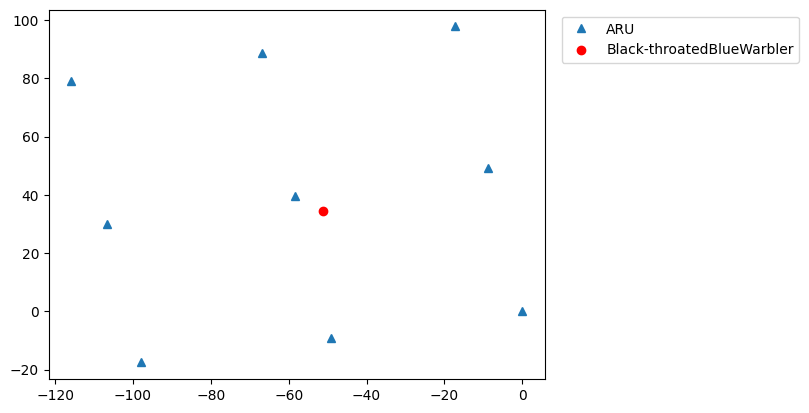

In [24]:
plt.plot(aru_coords["x"], aru_coords["y"], "^", label = "ARU")
plt.scatter(x = example.location_estimate[0], y = example.location_estimate[1], color = "red", label = f"{example.class_name}")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()

But we have multiple different estimates for the event, given by the different SpatialEvents. So we can plot all the location estimates in this time-window for Black-throated blue warbler. Given the small size of this array, these are all likely estimates of the same bird singing. In fact in this case, we used a speaker to broadcast the sounds, so we know there was only one sound source. So the multiple dots on the plot below give us multiple estimates of the same the single sound event, each using a different ARU as the reference receiver. Ideally the position estimates would all be in the same place, and we'd be confident we're localizing a single bird with high precision. In fact, we see that the estimates are all over the place!

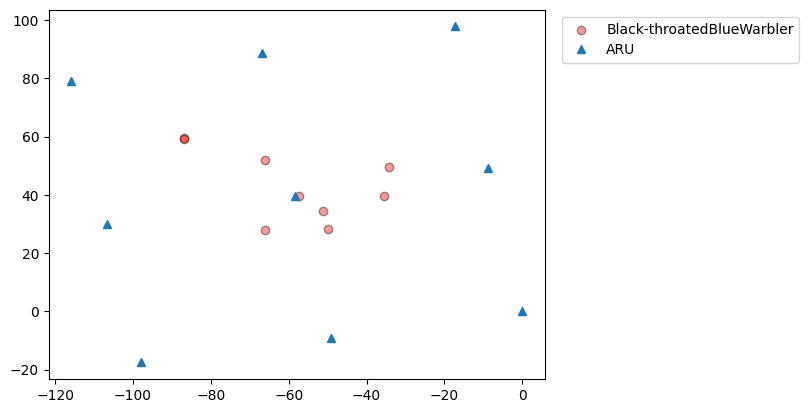

In [25]:
black_throated_blue_warblers = [e for e in localized_events if e.class_name ==example.class_name and e.start_time==example.start_time] # get all the SpatialEvents in this time-window attributed to Black-throatedBlueWarbler
x_coords = [e.location_estimate[0] for e in black_throated_blue_warblers] # get the x-coordinates of the estimated locations
y_coords = [e.location_estimate[1] for e in black_throated_blue_warblers] # get the y-coordinates of the estimated locations
plt.scatter(x_coords, y_coords, color = "red", label = "Black-throatedBlueWarbler", alpha = 0.4, edgecolors="black") # plot the estimated locations
plt.plot(aru_coords["x"], aru_coords["y"], "^", label = "ARU") # plot the ARU locations
# make the legend appear outside of the plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')


## 

## Filter out bad localizations

One of the reasons we have multiple estimated positions that disagree with each other, is we did not filter the estimated positions by any measure of confidence in the estimated position. An error metric we can use is to look at how well the measured TDOAs between the receivers match the estimated position. To summarize this in a single metric, we use the root-mean square (or L2 norm) of the TDOA residuals (measured in meters). This is a single number, that gives a measure of how well the time-delays agree with what we would expect given the estimated location. You can access the `residual_rms` attribute of the `SpatialEvent` object to get this number.

A `residual_rms` of less than 5m suggests a sound-source location has been estimated with high precision. We can filter out the high-error SpatialEvents and plot only the precise ones. As these recordings actually came from a speaker playing recordings of a Black-throated Blue Warbler, we can compare this estimated position of thes to the true known position. Which was `-86.440, 58.861`. 

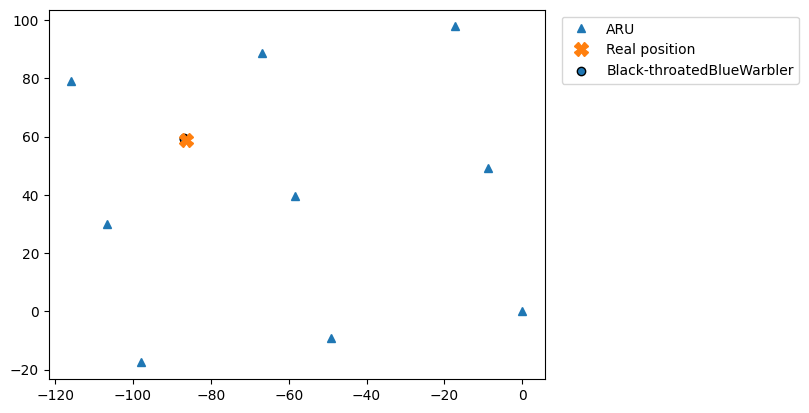

In [26]:
# plt.scatter(x_coords, y_coords, c = TDOA_residual_rms, cmap = "plasma", edgecolor = "black", label = "Black-throatedBlueWarbler") # plot the estimated locations
low_rms = [e for e in black_throated_blue_warblers if e.residual_rms < 5] # get only the events with low residual rms
plt.plot(aru_coords["x"], aru_coords["y"], "^", label = "ARU") # plot the ARU locations
plt.plot(-86.440, 58.861, "X", markersize = 10, label = "Real position") # plot the ARU locations
plt.scatter([e.location_estimate[0] for e in low_rms], [e.location_estimate[1] for e in low_rms], edgecolor = "black", label = "Black-throatedBlueWarbler") # plot the estimated locations
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

## Tune localization parameters
There are also a number of parameters you might wish to experiment with, or tune to try and optimize your results. This includes only returning the localized positions with low error, like we did manually above.
- `cc_filter` : The filter applied to the signals cross-correlation. Depending on the acoustic properties of your setting, a different filter may improve TDOA estimation.
- `cc_threshold` : When estimating the TDOA, we find the time-delay that maximizes cross-correlation. You can filter out TDOAs estimated from only poorly-matching audio by increasing the `cc_threshold`. The `cc_threshold` you choose to use will also depend on the `cc_filter` used.
- `residual_threshold` : Once a location is estimated from the TDOAs, you will want to filter out positions that poorly match the observed TDOAs. Setting a low `residual_threshold` will do this.
- `bandpass_ranges` : The frequency ranges to bandpass your audio to before estimating TDOAs. This helps improve time-delay estimation.
- `localization_algorithm` : There are multiple ways to try and solve the location from a set of TDOAs. We have implemented both the Gillette & Silverman algorithm & Soundfinder (GPS) algorithm


In [27]:
# parameters for localization
min_n_receivers = 4 #
max_receiver_dist = 100 #

# paramaters that can be tuned to increase the accuracy of the localization
bandpass_ranges = {"Black-throatedBlueWarbler": [5000,10000],
                    "ScarletTanager": [1000,5000],
                    "Black-throatedGreenWarbler": [5000,10000],
                   "Black-and-whiteWarbler": [5000,10000],
                   "AcadianFlycatcher": [2000,7000]}

cc_filter = "phat" # phase transform cross-correlation
residual_threshold = 5 # threshold for TDOA residual rms. TDOAs with a higher residual than this will be discarded
cc_threshold = 0.01 # threshold for cross-correlation score. TDOAs with a lower CC than this will be discarded. Can be increased to increase precision at the cost of recall
localization_algorithm = "gillette" # options: 'soundfinder', 'gillette'

localized_events = array.localize_detections(detections, 
                                            min_n_receivers = min_n_receivers, 
                                            max_receiver_dist=max_receiver_dist, 
                                            localization_algorithm=localization_algorithm,
                                            cc_threshold=cc_threshold,
                                            cc_filter=cc_filter,
                                            residual_threshold=residual_threshold)

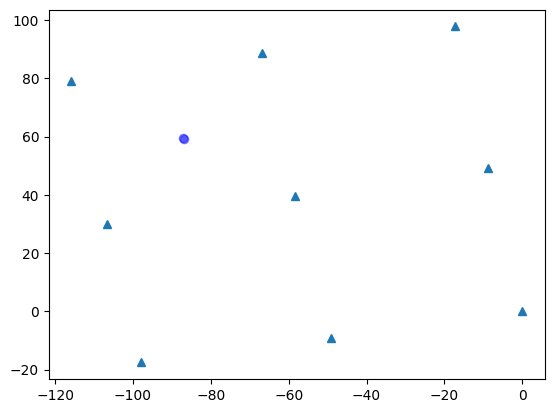

In [28]:
black_throated_blue_warblers = [e for e in localized_events if e.class_name =="Black-throatedBlueWarbler" and e.start_time == 6.0] # get all the SpatialEvents attributed to Black-throatedBlueWarbler
x_coords = [e.location_estimate[0] for e in black_throated_blue_warblers] # get the x-coordinates of the estimated locations
y_coords = [e.location_estimate[1] for e in black_throated_blue_warblers] # get the y-coordinates of the estimated locations
plt.scatter(x_coords, y_coords, color = "blue", label = "Black-throatedBlueWarbler", alpha = 0.4) # plot the estimated locations
plt.plot(aru_coords["x"], aru_coords["y"], "^", label = "ARU") # plot the ARU locations

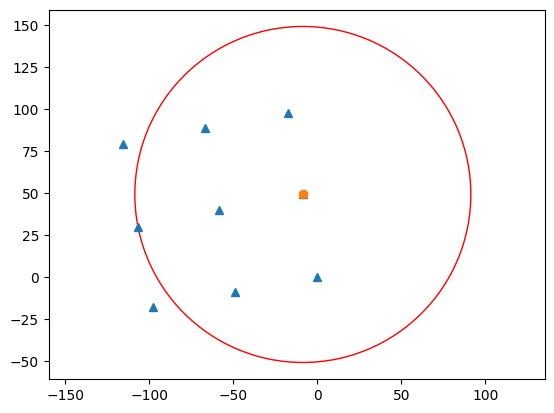

In [29]:
# we can plot this information on a map. Make the x and y axes equal
plt.plot(aru_coords["x"], aru_coords["y"], "^", label = "ARU")
plt.axis('equal')
# make a circle of radius max_receiver_dist around the reference aru
ref_coords = aru_coords.loc[example.receiver_files[0]]
plt.plot(ref_coords["x"], ref_coords["y"], "o", label = "Reference ARU")
circle = plt.Circle((ref_coords["x"], ref_coords["y"]), max_receiver_dist, color='r', fill=False)
plt.gca().add_patch(circle)

**Clean up:** Run the following cell to delete the files you downloaded.

In [31]:
from pathlib import Path
for p in Path(".").glob("R*_callibrated.WAV"):
    p.unlink()
Path("aru_coords.csv").unlink()
Path("detections.csv").unlink()